## Potato Plant Disease Detection

This project aims to detect diseases in potato plants using Convolutional Neural Networks (CNN). The model is designed to classify potato leaves into three categories: early blight, late blight, and healthy. By analyzing images of the leaves, the CNN can identify signs of disease and help farmers take timely action to protect their crops.

## Project Overview

Potato diseases, such as early blight and late blight, can significantly affect crop yield and quality. Early detection of these diseases is crucial for effective management and treatment. This project utilizes deep learning techniques to build a robust model that can accurately classify potato leaf images, aiding in the timely identification of plant health issues.

## Dataset Description

The dataset consists of three types of images of potato leaves, representing the following categories:


Early Blight: Images of potato leaves affected by early blight disease, characterized by dark lesions and yellowing of leaf edges.

Late Blight: Images of potato leaves affected by late blight disease, known for water-soaked lesions and a more rapid spread compared to early blight.

Healthy: Images of healthy potato leaves, showing no signs of disease.


### Importing Dependencies

In [18]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import pandas as pd

### Setting the Constants

In [19]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3    #RGB Channels

### Importing data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset

In [20]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [21]:
# Name of the classes
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [22]:
# Data is divided into 68 batches
len(dataset)

68

In [23]:
for image_batch, labels_batch in dataset.take(1):        #dataset.take(1) represents the 1st batch
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 0 1 0 1 0 0 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 0 1 1 0]


### Visualizing Some images from th dataset

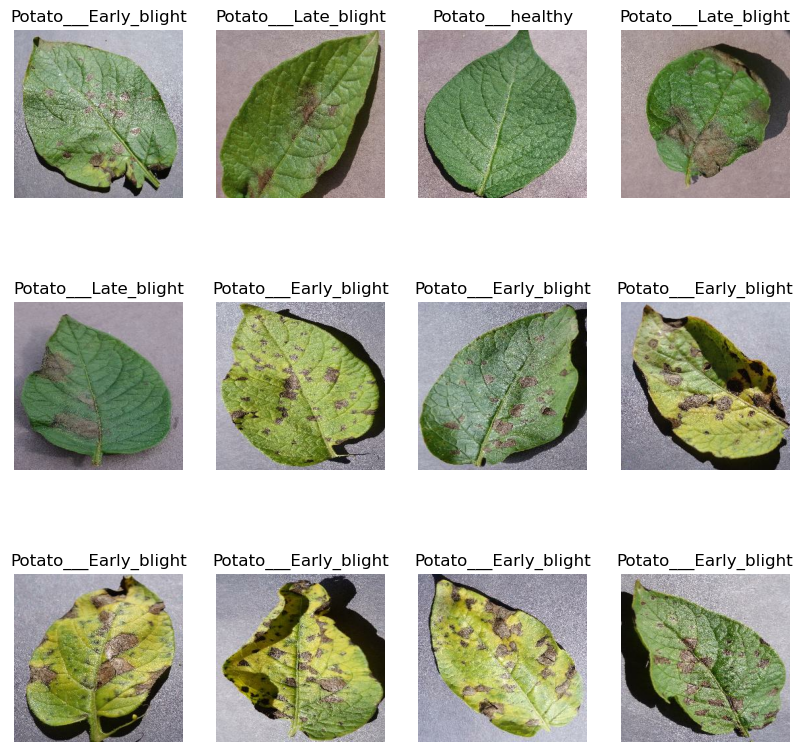

In [24]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_batch[i]])
        plt.axis('off')
        

### Splitting The Data

1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

80% ==> Training

20% ==> 10% Validation, 10% Test

In [25]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [26]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [27]:
print('Train :',len(train_ds))
print('Validation :',len(val_ds))
print('Test :',len(test_ds))

Train : 54
Validation : 6
Test : 8


### Cache, Shuffle & Prefetch the Dataset

cache(): This operation saves the processed data in memory after the first time it's loaded. This speeds up data retrieval during subsequent epochs because it avoids reloading and reprocessing the data.

shuffle(1000): This operation randomly shuffles the data within a buffer size of 1000 elements. Shuffling helps in training by ensuring that the model does not see the data in a fixed order, which can improve the model's ability to generalize.

prefetch(buffer_size=tf.data.AUTOTUNE): This operation prepares the next batch of data while the current batch is being processed. The buffer_size=tf.data.AUTOTUNE argument lets TensorFlow decide the optimal buffer size to use, which helps improve data pipeline efficiency and speed up training.

In [28]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Resize and Scaling
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [29]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

### Model Building


In [31]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [32]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

### Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [33]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [34]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=35,
)

Epoch 1/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.4364 - loss: 0.9743 - val_accuracy: 0.4635 - val_loss: 0.9169
Epoch 2/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.4698 - loss: 0.9078 - val_accuracy: 0.7500 - val_loss: 0.6573
Epoch 3/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.6948 - loss: 0.6940 - val_accuracy: 0.7969 - val_loss: 0.5401
Epoch 4/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8060 - loss: 0.4849 - val_accuracy: 0.7344 - val_loss: 0.5569
Epoch 5/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8041 - loss: 0.4636 - val_accuracy: 0.8802 - val_loss: 0.3137
Epoch 6/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8813 - loss: 0.3111 - val_accuracy: 0.8646 - val_loss: 0.3427
Epoch 7/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9022 - loss: 0.2737 - val_accuracy: 0.9167 - val_loss: 0.1813
Epoch 8/35
54/54 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9269 - loss: 0.1838 - val_accuracy: 0.9479 - val_loss:

In [35]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 417ms/step - accuracy: 0.9899 - loss: 0.0304


###  we get 99% accuracy for our test dataset, it is a pretty good accuracy

### Plots for Accuracy and Loss 

In [38]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

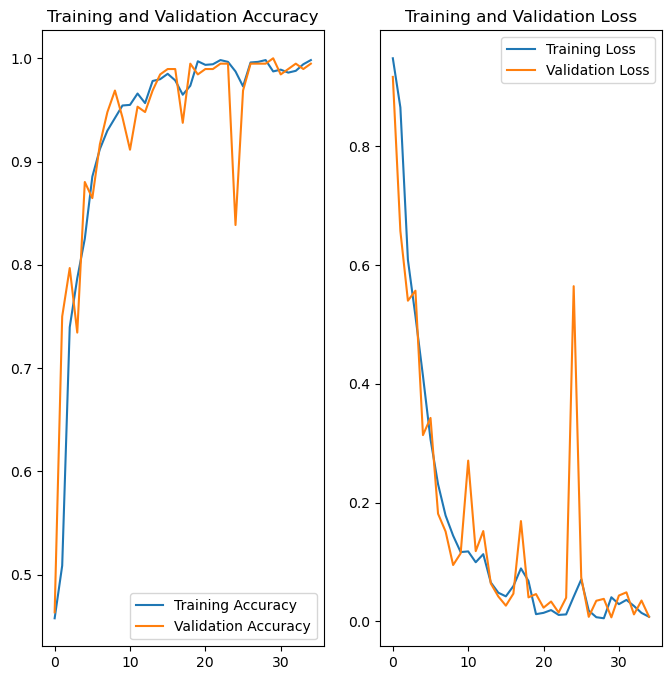

In [40]:
EPOCHS = 35

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Prediction on Sample Images

first image to predict
actual label: Potato___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
predicted label: Potato___healthy


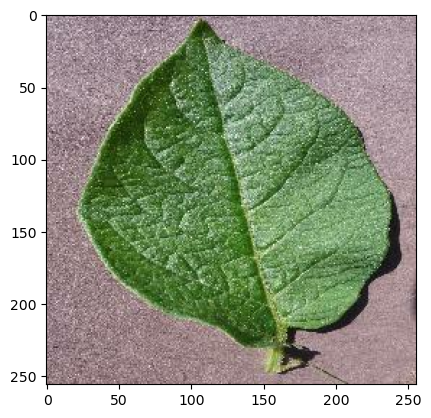

In [41]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [42]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


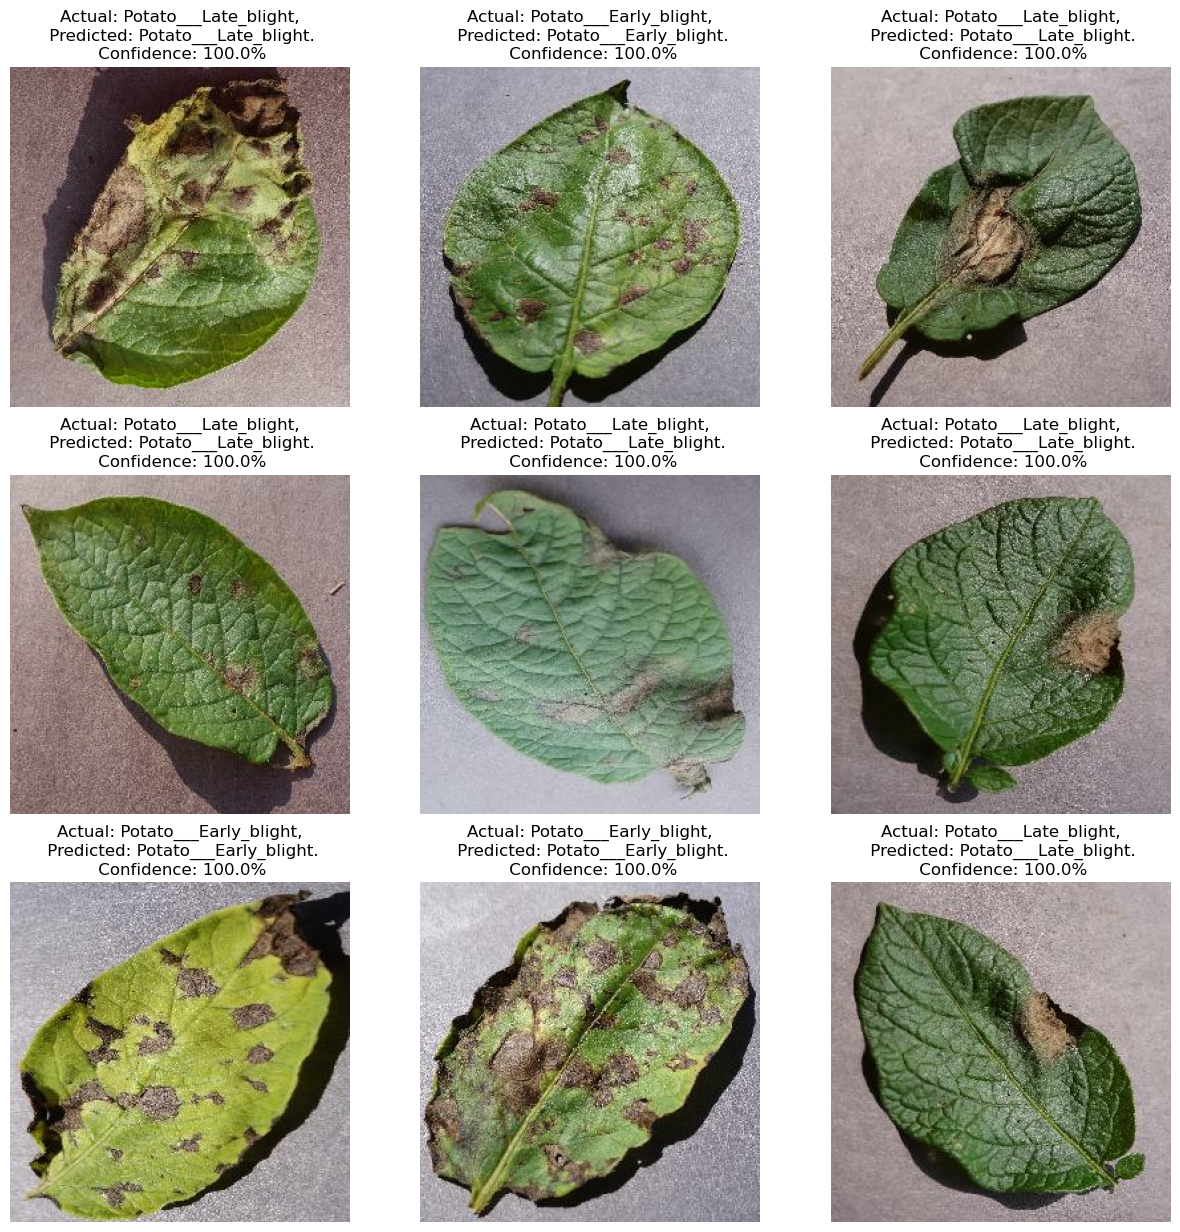

In [43]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### We can observe our model has predicted the class of each image accurately